This example shows a Total Lagrangian formulation based on 8-node quadrilateral elements. A point force in vertical direction is applied to the right tip of the beam, createing bending-type large displacements.


Converged at the outer iteration   1 with   5 inner iterations.
Converged at the outer iteration   2 with   5 inner iterations.
Converged at the outer iteration   3 with   5 inner iterations.
Converged at the outer iteration   4 with   5 inner iterations.
Converged at the outer iteration   5 with   5 inner iterations.
Converged at the outer iteration   6 with   5 inner iterations.
Converged at the outer iteration   7 with   7 inner iterations.
Converged at the outer iteration   8 with  12 inner iterations.
Converged at the outer iteration   9 with  13 inner iterations.
Converged at the outer iteration  10 with  15 inner iterations.
Converged at the outer iteration  11 with  10 inner iterations.
Converged at the outer iteration  12 with   8 inner iterations.
Converged at the outer iteration  13 with   8 inner iterations.
Converged at the outer iteration  14 with   8 inner iterations.
Converged at the outer iteration  15 with   8 inner iterations.
Converged at the outer iteration  16 wi

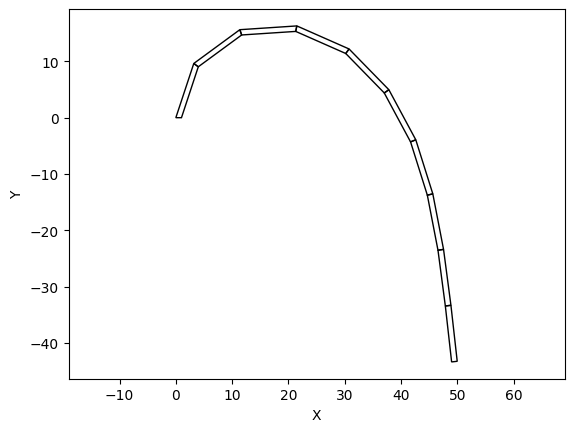

In [ ]:
import FEA
import numpy as np

# ====================== Problem Setup ======================
analysis = FEA.FEA()

mesh = analysis.LoadMesh("SlenderBeamBendingExample.msh", "quad8")
material = analysis.LinearElasticMaterial2D(E=8, nu=0.3)
discretization = analysis.Element8node2D()

# ====================== Dirichlet Boundary Conditions ======================
BC_fix_xdir = np.where(mesh.nodes[:, 1] == 0)[0]
BC_fix_ydir = BC_fix_xdir + mesh.ndofs_per_dimension
DirichletBC = analysis.DirichletBC(mesh, np.unique(np.concatenate([BC_fix_xdir, BC_fix_ydir])))

# ====================== Neumann Boundary Conditions ======================
# Find the node with maximum x and maximum y (tip corner)
index_tip = np.where((mesh.nodes[:, 0] == mesh.nodes[:, 0].max()) & (mesh.nodes[:, 1] == mesh.nodes[:, 1].max()))[0][0]
NeumannBC = analysis.NeumannBC().pointLoad(0, -2e-3, index_tip, mesh)

# ======================= TL Solver Setup =======================
U_history = analysis.GeometricNonlinearTL(mesh, material, discretization, DirichletBC, NeumannBC, steps=100)

# ======================= Post-Processing =======================
plt = analysis.DrawMesh2D(mesh, U_history[:, -1], scale=1)